In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("../details/new_ped_matrix.npy")

with open("../details/ped_dataset.pkl", "rb") as f:
    ped_dataset = pickle.load(f)
    
with open('../details/scene_info.pkl', 'rb') as handle:
    scene_info = pickle.load(handle)

In [3]:
nusc = NuScenes(version='v1.0-trainval', \
                dataroot='../../../../../data/', \
                verbose=False)

so_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [4]:
# # calculating the values for standardization for every feature
# mean_values = np.mean(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))
# std_values = np.std(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))

# # standardization
# total_ped_matrix = (total_ped_matrix - mean_values) / std_values

In [5]:
# train_test split

x_train = total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :]
x_train = x_train.reshape(TRAIN_SIZE, 42)
y_train = total_ped_matrix[:TRAIN_SIZE, TRAIN_TIME:, :2]

x_test = total_ped_matrix[TRAIN_SIZE:, :TRAIN_TIME, :]
x_test = x_test.reshape(len(total_ped_matrix)-TRAIN_SIZE, 42)
y_test = total_ped_matrix[TRAIN_SIZE:, TRAIN_TIME:, :2]

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [4]:
# defining the custom rmse loss function
def model_loss(gt, pred):
    '''
    calculates custom rmse loss between every time point
    '''
    pred_path = pred[:,:20]
    pred_path = tf.reshape(pred_path, [-1,10,2])
    gt = tf.reshape(gt, [-1,10,2])
    
    l2_x = K.square(gt[:,:,0] - pred_path[:,:,0])
    l2_y = K.square(gt[:,:,1] - pred_path[:,:,1])
    
    pred_sigma = pred[:,20:]
    pred_sigma = tf.reshape(pred_sigma, [-1,10,2])
    
    # log(sigma)
    logs_x = pred_sigma[:,:,0] * 0.5 
    logs_y = pred_sigma[:,:,1] * 0.5
    
    # sigma^2
    s_x = K.exp(pred_sigma[:,:,0])
    s_y = K.exp(pred_sigma[:,:,1])
    
    # weight for aleatoric loss
    w = 1.0
    
    r = (l2_x/(2*w*s_x)) + (l2_y/(2*w*s_y))
    return K.mean(r) + w*logs_x + w*logs_y

def euc_dist(gt, pred):
    # custom metric to monitor rmse
    gt_path = tf.reshape(gt, [-1,10,2])
    pred_path = pred[:,:20]
    pred_path = tf.reshape(pred_path, [-1,10,2])
    
    gt_x = gt_path[:,:,0]
    gt_y = gt_path[:,:,1]
    
    pred_x = pred_path[:,:,0]
    pred_y = pred_path[:,:,1]
    
    rmse = K.mean(K.sqrt(K.sum(K.square(gt_path - pred_path), axis=1)))
    return rmse

In [8]:
# defining the model
traj_input = Input(shape=(x_train.shape[1]))

x = Dense(32, activation='relu')(traj_input)

x_reg = Dense(20, activation='linear')(x)
x_sig = Dense(20, activation='tanh')(x)

combined_output = concatenate([x_reg, x_sig], axis=-1)
umlp_model = Model(inputs=[traj_input], outputs=[combined_output])

umlp_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                       loss=model_loss, metrics=[euc_dist])

In [9]:
umlp_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1376        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           660         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           660         dense[0][0]                      
______________________________________________________________________________________________

In [14]:
# checkpoint for saving the best model
# filepath="../checkpoints/uncertain_mlp_best.hdf5"
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_euc_dist', 
#                                                 verbose=2, save_best_only=True, 
#                                                 save_weights_only=False,
#                                                 mode='min')
# callbacks_list = [checkpoint]

train_history = umlp_model.fit(train_data, epochs=30,
                               verbose=2, callbacks=None,
                               validation_data=val_data,
                               steps_per_epoch=400,
                               validation_steps=60
                             )

Train for 400 steps, validate for 60 steps
Epoch 1/30
400/400 - 2s - loss: 1.7688 - euc_dist: 2.9632 - val_loss: -5.9157e-01 - val_euc_dist: 0.7943
Epoch 2/30
400/400 - 1s - loss: -6.0528e-01 - euc_dist: 0.7617 - val_loss: -7.0367e-01 - val_euc_dist: 0.6455
Epoch 3/30
400/400 - 1s - loss: -6.6976e-01 - euc_dist: 0.6748 - val_loss: -7.3807e-01 - val_euc_dist: 0.5955
Epoch 4/30
400/400 - 1s - loss: -6.9817e-01 - euc_dist: 0.6457 - val_loss: -7.4784e-01 - val_euc_dist: 0.5890
Epoch 5/30
400/400 - 1s - loss: -6.9184e-01 - euc_dist: 0.6448 - val_loss: -7.4980e-01 - val_euc_dist: 0.5984
Epoch 6/30
400/400 - 1s - loss: -7.0833e-01 - euc_dist: 0.6370 - val_loss: -7.1602e-01 - val_euc_dist: 0.6362
Epoch 7/30
400/400 - 1s - loss: -7.1262e-01 - euc_dist: 0.6266 - val_loss: -7.4515e-01 - val_euc_dist: 0.5760
Epoch 8/30
400/400 - 1s - loss: -7.1073e-01 - euc_dist: 0.6240 - val_loss: -7.5004e-01 - val_euc_dist: 0.6129
Epoch 9/30
400/400 - 1s - loss: -7.1301e-01 - euc_dist: 0.6277 - val_loss: -7.5230

In [37]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

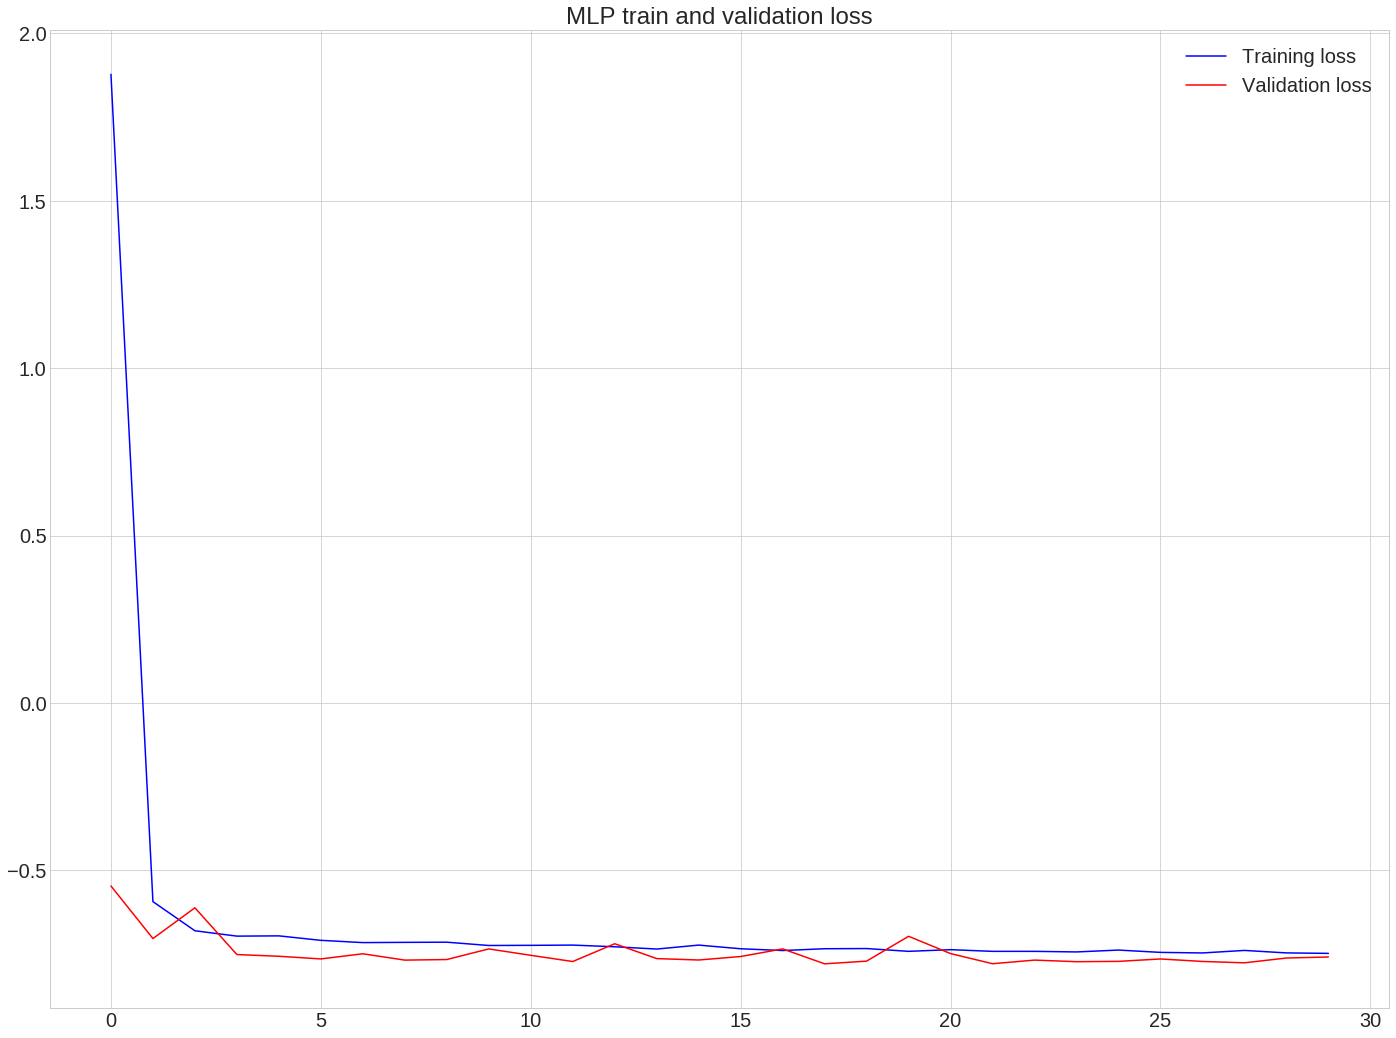

In [38]:
plot_train_history(train_history, "MLP train and validation loss")

In [5]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = 0.0
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss += ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    return (loss / float(len(l1))) 

In [6]:
# loading the model
umlp_model = tf.keras.models.load_model("../checkpoints/uncertain_mlp_best.hdf5", compile=False)

umlp_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                 loss=model_loss, 
                 metrics=[euc_dist])

In [7]:
indexes = [9804, 9805, 11662, 12201, 11984, 11980, 11334, 11682, 11232, 
           11179, 9821, 10245, 10369]

for test_idx in indexes:
    for i in np.linspace(0,9,4):
        i = int(i)
        
        # color setting for plot
        alphas = np.linspace(1, 0.3, 10)

        # for red the first column needs to be one
        red_colors = np.zeros((10,4))
        red_colors[:,0] = 1.0
        # the fourth column needs to be your alphas
        red_colors[:, 3] = alphas

        # for red the first column needs to be one
        blue_colors = np.zeros((10,4))
        blue_colors[:,2] = 1.0
        # the fourth column needs to be your alphas
        blue_colors[:, 3] = alphas
        
        test_data = np.reshape(total_ped_matrix[test_idx,i:i+6,:]
                               , (1, 42))
        predictions = umlp_model.predict(test_data)[0][:20].reshape(-1, 2)
        predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                       ped_dataset[test_idx]["origin"])

        n_scene = ped_dataset[test_idx]["scene_no"]
        ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_pedposes_on_fancy_map(
                        nusc, scene_tokens=[nusc.scene[n_scene]['token']], 
                        ped_path = np.array(ped_dataset[test_idx]["translation"])[:,:2],
                        verbose=False,
                        render_egoposes=True, render_egoposes_range=False, 
                        render_legend=True)

        plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[i:i+6,:2]), 
                    c='k', s=5, zorder=2)
        plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[i+6:,:2]), 
                    c='b', s=5, zorder=3)
        plt.scatter(*zip(*predictions), color=red_colors, s=5, zorder=4)
        plt.savefig(f"../images/diffsteps_mlp/{test_idx}_{i}steps.png", bbox_inches='tight', pad_inches=0)
        plt.close()
    
#     loss = rmse_error(predictions, np.array(ped_dataset[test_idx]["translation"])[6:,:2])
        
#     final_loss = rmse_error(predictions[-1], 
#                             np.array(ped_dataset[test_idx]["translation"])[-1,:2])

    
#     print(f"Loss in m is {loss}")
#     print(f"Loss of final position in m is {final_loss}")